In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import nltk
import string
from collections import Counter

from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from pprint import pprint
import pickle
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, classification_report, average_precision_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

[nltk_data] Downloading package stopwords to /home/cst/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/cst/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/cst/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Using TensorFlow backend.


# Functions

In [2]:
def save_as_pickle(filename,obj):    
    with open(filename, 'wb') as fp:
        pickle.dump(obj, fp, protocol=pickle.HIGHEST_PROTOCOL)
    fp.close()

In [3]:
if not os.path.exists('comment_data'):
    os.makedirs('comment_data')

In [4]:
xls = pd.ExcelFile('Comment Spam.xls')
data = xls.parse('Data Train')

In [5]:
data.shape

(1300, 3)

In [6]:
data.head()

,No,Comment,Class
0,1,this song is racist,0
1,2,and how many subscribers compared to her over ...,1
2,3,HI! CHECK OUT OUR AWESOME COVERS! AND SAY WHAT...,1
3,4,well done shakira,0
4,5,:D subscribe to me for daily vines,1


In [7]:
data.isnull().sum()

No         0
Comment    0
Class      0
dtype: int64

<b>No missing data</b>

In [8]:
data['Class'].value_counts()

1    669
0    631
Name: Class, dtype: int64

In [9]:
data['Class'].value_counts(normalize=True)

1    0.514615
0    0.485385
Name: Class, dtype: float64

<b>No issue with imbalance data.</b>

In [10]:
data['characters_length'] = data['Comment'].str.len()

In [11]:
data.head()

,No,Comment,Class,characters_length
0,1,this song is racist,0,19
1,2,and how many subscribers compared to her over ...,1,55
2,3,HI! CHECK OUT OUR AWESOME COVERS! AND SAY WHAT...,1,57
3,4,well done shakira,0,17
4,5,:D subscribe to me for daily vines,1,34


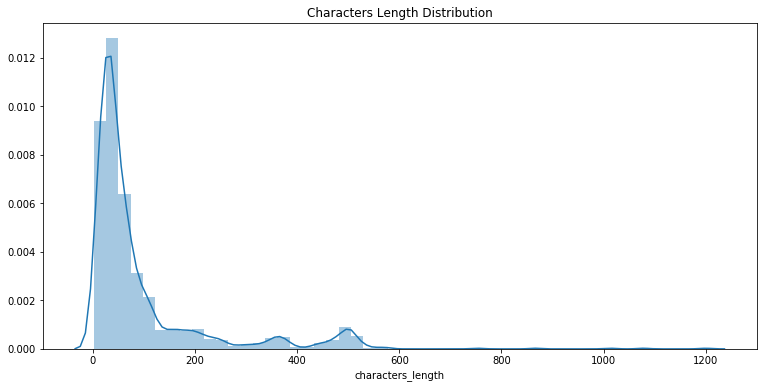

In [12]:
plt.figure(figsize=(12.8,6))
sns.distplot(data['characters_length']).set_title('Characters Length Distribution');

<b>Characters length is skewed.</b>

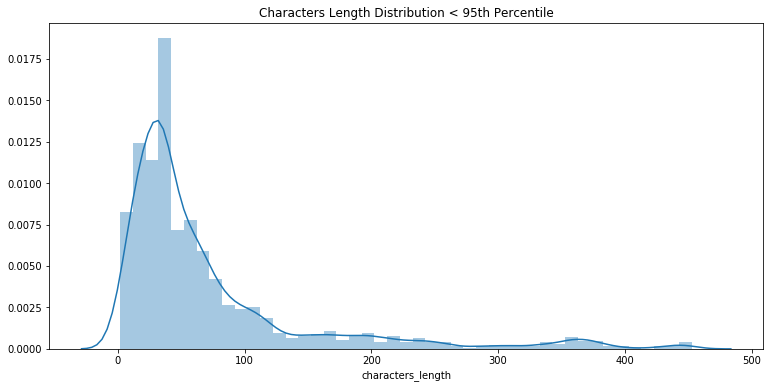

In [13]:
plt.figure(figsize=(12.8,6))
sns.distplot(data[data['characters_length']<np.quantile(data['characters_length'],0.95)]['characters_length']).set_title('Characters Length Distribution < 95th Percentile');

In [14]:
print(data[data['characters_length'] <= np.quantile(data['characters_length'],0.95)].shape[0]/data.shape[0])
print(data[data['characters_length'] > np.quantile(data['characters_length'],0.95)].shape[0]/data.shape[0])

0.95
0.05


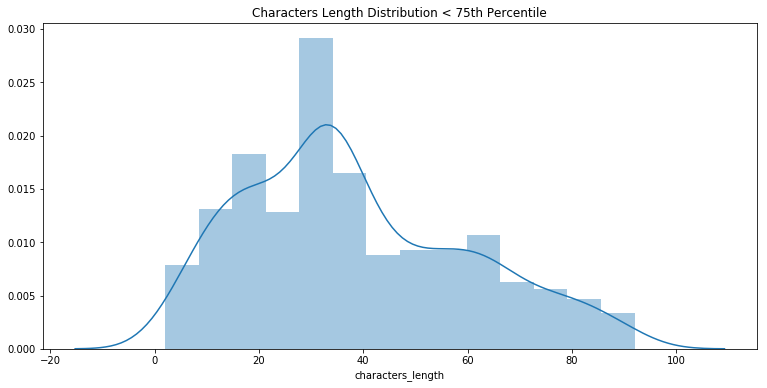

In [15]:
plt.figure(figsize=(12.8,6))
sns.distplot(data[data['characters_length']<np.quantile(data['characters_length'],0.75)]['characters_length']).set_title('Characters Length Distribution < 75th Percentile');

In [16]:
print(data[data['characters_length'] <= np.quantile(data['characters_length'],0.75)].shape[0]/data.shape[0])
print(data[data['characters_length'] > np.quantile(data['characters_length'],0.75)].shape[0]/data.shape[0])

0.7507692307692307
0.24923076923076923


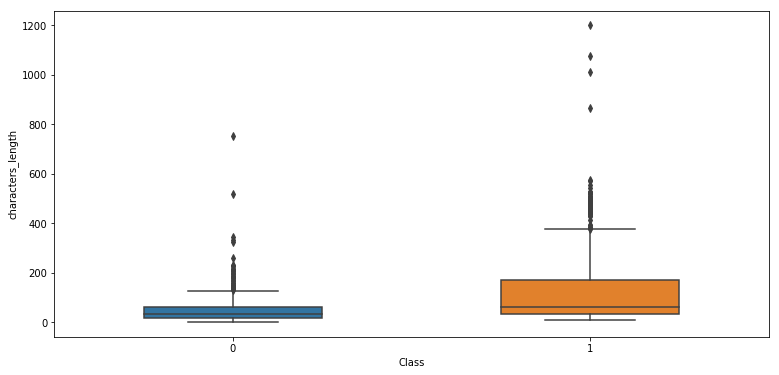

In [17]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=data, x='Class', y='characters_length', width=.5);

<b>Biggest outliers are in `Technology` and `Entertainment` categories.</b>

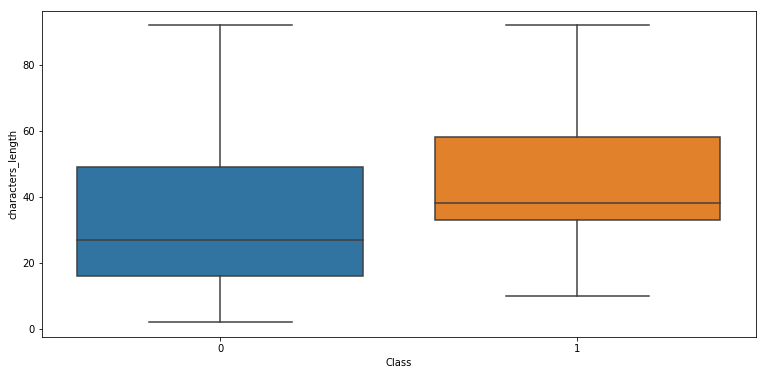

In [18]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=data[data['characters_length']<np.quantile(data['characters_length'],0.75)], x='Class', y='characters_length');

<b>It seems that `Characters Length` does not affecting `Category`. Data looks normal if the outliers data is not included</b>

In [19]:
Counter(" ".join(data["Comment"]).split()).most_common(10)

[('the', 436),
 ('and', 408),
 ('to', 397),
 ('I', 394),
 ('this', 392),
 ('a', 323),
 ('out', 300),
 ('my', 298),
 ('on', 246),
 ('you', 237)]

In [20]:
Counter(" ".join(data[data['Class']==0]["Comment"]).split()).most_common(10)

[('the', 158),
 ('this', 139),
 ('I', 136),
 ('is', 132),
 ('and', 87),
 ('to', 86),
 ('song', 78),
 ('love', 64),
 ('of', 62),
 ('a', 62)]

In [21]:
Counter(" ".join(data[data['Class']==1]["Comment"]).split()).most_common(10)

[('and', 321),
 ('to', 311),
 ('out', 293),
 ('the', 278),
 ('my', 269),
 ('a', 261),
 ('I', 258),
 ('this', 253),
 ('on', 218),
 ('you', 201)]

<b>Many irrelevant words dominating the most frequent appear words and it spread out across categories. Data cleansing should be able to handle this situation.</b>

# Summary

1. No missing data.
2. No data imbalance issue
3. `Characters Length` seems impact the Class disribution a bit.
4. Many irrelevant words dominating the most frequent appear words and it spread out across class.

# Data Preparation 

In [22]:
target = 'Class'
features = [item for item in data.columns if item!=target]
features

['No', 'Comment', 'characters_length']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(data[features], 
                                                    data[target], 
                                                    test_size=0.2, 
                                                    random_state=42)

In [24]:
# pd.concat([X_train, y_train], axis=1).to_csv('comment_data/train.csv')
# pd.concat([X_test, y_test], axis=1).to_csv('comment_data/valid.csv')

# Text cleaning

In [25]:
X_train.head()

,No,Comment,characters_length
10,11,I hope everyone is in good spirits I&#39;m a h...,507
147,148,Hello Guys...I Found a Way to Make Money Onlin...,498
342,343,This video will get to 2 billion just because ...,95
999,1000,OMG that looks just like a piece of the mirror...,127
811,812,Check out this video on YouTube:﻿,33


In [26]:
special_characters = string.punctuation

def strip_character(dataCol):
    r = re.compile(r'[^a-zA-Z !@#$%&*_+-=|\:";<>,./()[\]{}\']')
    return r.sub('', dataCol)

def remove_numbers(dataCol):
    return re.sub(r'\d+', '', dataCol)

def remove_non_words(dataCol):
    return re.sub(r"\W", " ", dataCol, flags=re.I)

def remove_single_character(dataCol):
    return re.sub(r"\s+[a-zA-Z]\s+", " ", dataCol)

In [27]:
def remove_possesive_pronouns(data):
    # Remove possesive pronouns first
    data['Content_Parsed_1'] = data['Comment'].str.replace("'s", "")
    data['Content_Parsed_1'] = data['Content_Parsed_1'].str.replace("$", " money ")
    
    return data

X_train = remove_possesive_pronouns(X_train)
X_test = remove_possesive_pronouns(X_test)

In [28]:
X_train.head()

,No,Comment,characters_length,Content_Parsed_1
10,11,I hope everyone is in good spirits I&#39;m a h...,507,I hope everyone is in good spirits I&#39;m a h...
147,148,Hello Guys...I Found a Way to Make Money Onlin...,498,Hello Guys...I Found a Way to Make Money Onlin...
342,343,This video will get to 2 billion just because ...,95,This video will get to 2 billion just because ...
999,1000,OMG that looks just like a piece of the mirror...,127,OMG that looks just like a piece of the mirror...
811,812,Check out this video on YouTube:﻿,33,Check out this video on YouTube:﻿


In [29]:
def remove_special_characters(data):
    # Remove special characters
    data['Content_Parsed_2'] = data['Content_Parsed_1'].str.replace("\t", " ")
    data['Content_Parsed_2'] = data['Content_Parsed_2'].str.replace("\n", " ")
    data['Content_Parsed_2'] = data['Content_Parsed_2'].str.replace('"', '')
    data['Content_Parsed_2'] = data['Content_Parsed_2'].apply(strip_character)
    data['Content_Parsed_2'] = data['Content_Parsed_2'].apply(remove_numbers)
    data['Content_Parsed_2'] = data['Content_Parsed_2'].apply(remove_non_words)
    data['Content_Parsed_2'] = data['Content_Parsed_2'].apply(remove_single_character)
    
    return data

X_train = remove_special_characters(X_train)
X_test = remove_special_characters(X_test)

In [30]:
X_train.head()

,No,Comment,characters_length,Content_Parsed_1,Content_Parsed_2
10,11,I hope everyone is in good spirits I&#39;m a h...,507,I hope everyone is in good spirits I&#39;m a h...,I hope everyone is in good spirits m hard work...
147,148,Hello Guys...I Found a Way to Make Money Onlin...,498,Hello Guys...I Found a Way to Make Money Onlin...,Hello Guys Found Way to Make Money Online You ...
342,343,This video will get to 2 billion just because ...,95,This video will get to 2 billion just because ...,This video will get to billion just because o...
999,1000,OMG that looks just like a piece of the mirror...,127,OMG that looks just like a piece of the mirror...,OMG that looks just like piece of the mirror o...
811,812,Check out this video on YouTube:﻿,33,Check out this video on YouTube:﻿,Check out this video on YouTube


<b>Some special characters still exist.</b>

In [31]:
def remove_special_character_2(data):
    
    # Remove left special characters    
    data['Content_Parsed_3'] = data['Content_Parsed_2']
    additional_special_characters = list("!”#$%&’()*+,-./:;<=>?@[\]^_`{|}~")
    for item in additional_special_characters:
        data['Content_Parsed_3'] = data['Content_Parsed_3'].str.replace(item, '')
    
    return data

X_train = remove_special_character_2(X_train)
X_test = remove_special_character_2(X_test)

In [32]:
X_train.head()

,No,Comment,characters_length,Content_Parsed_1,Content_Parsed_2,Content_Parsed_3
10,11,I hope everyone is in good spirits I&#39;m a h...,507,I hope everyone is in good spirits I&#39;m a h...,I hope everyone is in good spirits m hard work...,I hope everyone is in good spirits m hard work...
147,148,Hello Guys...I Found a Way to Make Money Onlin...,498,Hello Guys...I Found a Way to Make Money Onlin...,Hello Guys Found Way to Make Money Online You ...,Hello Guys Found Way to Make Money Online You ...
342,343,This video will get to 2 billion just because ...,95,This video will get to 2 billion just because ...,This video will get to billion just because o...,This video will get to billion just because o...
999,1000,OMG that looks just like a piece of the mirror...,127,OMG that looks just like a piece of the mirror...,OMG that looks just like piece of the mirror o...,OMG that looks just like piece of the mirror o...
811,812,Check out this video on YouTube:﻿,33,Check out this video on YouTube:﻿,Check out this video on YouTube,Check out this video on YouTube


In [33]:
def lower_text(data):
    data['Content_Parsed_4'] = data['Content_Parsed_3'].str.lower()
    return data

X_train = lower_text(X_train)
X_test = lower_text(X_test)

In [34]:
X_train.head()

,No,Comment,characters_length,Content_Parsed_1,Content_Parsed_2,Content_Parsed_3,Content_Parsed_4
10,11,I hope everyone is in good spirits I&#39;m a h...,507,I hope everyone is in good spirits I&#39;m a h...,I hope everyone is in good spirits m hard work...,I hope everyone is in good spirits m hard work...,i hope everyone is in good spirits m hard work...
147,148,Hello Guys...I Found a Way to Make Money Onlin...,498,Hello Guys...I Found a Way to Make Money Onlin...,Hello Guys Found Way to Make Money Online You ...,Hello Guys Found Way to Make Money Online You ...,hello guys found way to make money online you ...
342,343,This video will get to 2 billion just because ...,95,This video will get to 2 billion just because ...,This video will get to billion just because o...,This video will get to billion just because o...,this video will get to billion just because o...
999,1000,OMG that looks just like a piece of the mirror...,127,OMG that looks just like a piece of the mirror...,OMG that looks just like piece of the mirror o...,OMG that looks just like piece of the mirror o...,omg that looks just like piece of the mirror o...
811,812,Check out this video on YouTube:﻿,33,Check out this video on YouTube:﻿,Check out this video on YouTube,Check out this video on YouTube,check out this video on youtube


In [35]:
def stemming_lemmatization(data):
    
    wordnet_lemmatizer = WordNetLemmatizer()
    
    nrows = len(data)
    lemmatized_text_list = []

    for row in range(0, nrows):

        # Create an empty list containing lemmatized words
        lemmatized_list = []

        # Save the text and its words into an object
        text = data.iloc[row]['Content_Parsed_4']
        text_words = text.split(" ")

        # Iterate through every word to lemmatize
        for word in text_words:
            lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))

        # Join the list
        lemmatized_text = " ".join(lemmatized_list)

        # Append to the list containing the texts
        lemmatized_text_list.append(lemmatized_text)
    
    data['Content_Parsed_5'] = lemmatized_text_list
    
    return data

In [36]:
X_train = stemming_lemmatization(X_train)
X_test = stemming_lemmatization(X_test)

In [37]:
X_train.head()

,No,Comment,characters_length,Content_Parsed_1,Content_Parsed_2,Content_Parsed_3,Content_Parsed_4,Content_Parsed_5
10,11,I hope everyone is in good spirits I&#39;m a h...,507,I hope everyone is in good spirits I&#39;m a h...,I hope everyone is in good spirits m hard work...,I hope everyone is in good spirits m hard work...,i hope everyone is in good spirits m hard work...,i hope everyone be in good spirit m hard work ...
147,148,Hello Guys...I Found a Way to Make Money Onlin...,498,Hello Guys...I Found a Way to Make Money Onlin...,Hello Guys Found Way to Make Money Online You ...,Hello Guys Found Way to Make Money Online You ...,hello guys found way to make money online you ...,hello guy find way to make money online you ca...
342,343,This video will get to 2 billion just because ...,95,This video will get to 2 billion just because ...,This video will get to billion just because o...,This video will get to billion just because o...,this video will get to billion just because o...,this video will get to billion just because o...
999,1000,OMG that looks just like a piece of the mirror...,127,OMG that looks just like a piece of the mirror...,OMG that looks just like piece of the mirror o...,OMG that looks just like piece of the mirror o...,omg that looks just like piece of the mirror o...,omg that look just like piece of the mirror of...
811,812,Check out this video on YouTube:﻿,33,Check out this video on YouTube:﻿,Check out this video on YouTube,Check out this video on YouTube,check out this video on youtube,check out this video on youtube


In [38]:
def remove_stop_words(data):
    
    stop_words = list(stopwords.words('english'))
    
    data['Content_Parsed_6'] = data['Content_Parsed_5']

    for stop_word in stop_words:

        regex_stopword = r"\b" + stop_word + r"\b"
        data['Content_Parsed_6'] = data['Content_Parsed_6'].str.replace(regex_stopword, '')
        
    return data

In [39]:
X_train = remove_stop_words(X_train)
X_test = remove_stop_words(X_test)

In [40]:
X_train.head()

,No,Comment,characters_length,Content_Parsed_1,Content_Parsed_2,Content_Parsed_3,Content_Parsed_4,Content_Parsed_5,Content_Parsed_6
10,11,I hope everyone is in good spirits I&#39;m a h...,507,I hope everyone is in good spirits I&#39;m a h...,I hope everyone is in good spirits m hard work...,I hope everyone is in good spirits m hard work...,i hope everyone is in good spirits m hard work...,i hope everyone be in good spirit m hard work ...,hope everyone good spirit hard work studen...
147,148,Hello Guys...I Found a Way to Make Money Onlin...,498,Hello Guys...I Found a Way to Make Money Onlin...,Hello Guys Found Way to Make Money Online You ...,Hello Guys Found Way to Make Money Online You ...,hello guys found way to make money online you ...,hello guy find way to make money online you ca...,hello guy find way make money online get pa...
342,343,This video will get to 2 billion just because ...,95,This video will get to 2 billion just because ...,This video will get to billion just because o...,This video will get to billion just because o...,this video will get to billion just because o...,this video will get to billion just because o...,video get billion people check hit ...
999,1000,OMG that looks just like a piece of the mirror...,127,OMG that looks just like a piece of the mirror...,OMG that looks just like piece of the mirror o...,OMG that looks just like piece of the mirror o...,omg that looks just like piece of the mirror o...,omg that look just like piece of the mirror of...,omg look like piece mirror harry potter ...
811,812,Check out this video on YouTube:﻿,33,Check out this video on YouTube:﻿,Check out this video on YouTube,Check out this video on YouTube,check out this video on youtube,check out this video on youtube,check video youtube


In [41]:
def show_data_transformation(data,index):
    print('Original data:')
    print(data.iloc[index]['Comment'])
    print()
    print('After remove possesive pronouns:')
    print(data.iloc[index]['Content_Parsed_1'])
    print()
    print('After remove special characters:')
    print(data.iloc[index]['Content_Parsed_2'])
    print()
    print('After remove left special characters for 2nd times:')
    print(data.iloc[index]['Content_Parsed_3'])
    print()
    print('After lower the text:')
    print(data.iloc[index]['Content_Parsed_4'])
    print()
    print('After stemming and lemmatization:')
    print(data.iloc[index]['Content_Parsed_5'])
    print()
    print('After remove stop words:')
    print(data.iloc[index]['Content_Parsed_6'])
    

In [42]:
show_data_transformation(X_train,1)

Original data:
Hello Guys...I Found a Way to Make Money Online You Can Get Paid To Mess Around On Facebook And Twitter! GET PAID UPTO $25 to $35 AN HOUR...Only at 4NetJobs.com Work from the Comfort of your Home... They are Currently Hiring People from all Over the World, For a Wide Range of Social Media Jobs on Sites such as Facebook,Twitter and YouTube You don&#39;t Need any Prior Skills or Experience and You can Begin Work Immediately! You Can Easily Make $4000 to $5000+ Monthly Income…Only at 4NetJobs.com

After remove possesive pronouns:
Hello Guys...I Found a Way to Make Money Online You Can Get Paid To Mess Around On Facebook And Twitter! GET PAID UPTO $25 to $35 AN HOUR...Only at 4NetJobs.com Work from the Comfort of your Home... They are Currently Hiring People from all Over the World, For a Wide Range of Social Media Jobs on Sites such as Facebook,Twitter and YouTube You don&#39;t Need any Prior Skills or Experience and You can Begin Work Immediately! You Can Easily Make $4000

In [43]:
show_data_transformation(X_train,2)

Original data:
This video will get to 2 billion just because of people checking if it has  hit 2 billion yet.﻿

After remove possesive pronouns:
This video will get to 2 billion just because of people checking if it has  hit 2 billion yet.﻿

After remove special characters:
This video will get to  billion just because of people checking if it has  hit  billion yet 

After remove left special characters for 2nd times:
This video will get to  billion just because of people checking if it has  hit  billion yet 

After lower the text:
this video will get to  billion just because of people checking if it has  hit  billion yet 

After stemming and lemmatization:
this video will get to  billion just because of people check if it have  hit  billion yet 

After remove stop words:
 video  get   billion    people check     hit  billion yet 


In [44]:
X_train.head()

,No,Comment,characters_length,Content_Parsed_1,Content_Parsed_2,Content_Parsed_3,Content_Parsed_4,Content_Parsed_5,Content_Parsed_6
10,11,I hope everyone is in good spirits I&#39;m a h...,507,I hope everyone is in good spirits I&#39;m a h...,I hope everyone is in good spirits m hard work...,I hope everyone is in good spirits m hard work...,i hope everyone is in good spirits m hard work...,i hope everyone be in good spirit m hard work ...,hope everyone good spirit hard work studen...
147,148,Hello Guys...I Found a Way to Make Money Onlin...,498,Hello Guys...I Found a Way to Make Money Onlin...,Hello Guys Found Way to Make Money Online You ...,Hello Guys Found Way to Make Money Online You ...,hello guys found way to make money online you ...,hello guy find way to make money online you ca...,hello guy find way make money online get pa...
342,343,This video will get to 2 billion just because ...,95,This video will get to 2 billion just because ...,This video will get to billion just because o...,This video will get to billion just because o...,this video will get to billion just because o...,this video will get to billion just because o...,video get billion people check hit ...
999,1000,OMG that looks just like a piece of the mirror...,127,OMG that looks just like a piece of the mirror...,OMG that looks just like piece of the mirror o...,OMG that looks just like piece of the mirror o...,omg that looks just like piece of the mirror o...,omg that look just like piece of the mirror of...,omg look like piece mirror harry potter ...
811,812,Check out this video on YouTube:﻿,33,Check out this video on YouTube:﻿,Check out this video on YouTube,Check out this video on YouTube,check out this video on youtube,check out this video on youtube,check video youtube


In [45]:
X_train = X_train[features+['Content_Parsed_6']]
X_train = X_train.rename(columns={'Content_Parsed_6': 'Content_Parsed'})

X_test = X_test[features+['Content_Parsed_6']]
X_test = X_test.rename(columns={'Content_Parsed_6': 'Content_Parsed'})


X_train.head()

,No,Comment,characters_length,Content_Parsed
10,11,I hope everyone is in good spirits I&#39;m a h...,507,hope everyone good spirit hard work studen...
147,148,Hello Guys...I Found a Way to Make Money Onlin...,498,hello guy find way make money online get pa...
342,343,This video will get to 2 billion just because ...,95,video get billion people check hit ...
999,1000,OMG that looks just like a piece of the mirror...,127,omg look like piece mirror harry potter ...
811,812,Check out this video on YouTube:﻿,33,check video youtube


In [46]:
tmp_df = pd.concat([X_train, y_train], axis=1)

In [47]:
Counter(" ".join(tmp_df["Content_Parsed"]).split()).most_common(10)

[('check', 362),
 ('video', 181),
 ('com', 172),
 ('song', 149),
 ('youtube', 145),
 ('please', 136),
 ('like', 133),
 ('subscribe', 120),
 ('love', 120),
 ('make', 113)]

In [48]:
Counter(" ".join(tmp_df[tmp_df['Class']==0]["Content_Parsed"]).split()).most_common(10)

[('song', 114),
 ('love', 89),
 ('view', 56),
 ('like', 53),
 ('video', 47),
 ('br', 37),
 ('billion', 29),
 ('best', 29),
 ('katy', 26),
 ('get', 24)]

In [49]:
Counter(" ".join(tmp_df[tmp_df['Class']==1]["Content_Parsed"]).split()).most_common(10)

[('check', 349),
 ('com', 170),
 ('please', 135),
 ('video', 134),
 ('youtube', 126),
 ('subscribe', 119),
 ('channel', 104),
 ('make', 99),
 ('new', 91),
 ('http', 80)]

<b>Data looks more make sense after data cleaning.</b>

# Label Encoding

Encode the target feature

In [50]:
label_encoders = {}

In [51]:
label_encoders[target] = LabelEncoder()        
label_encoders[target].fit(y_train)  

y_train = label_encoders[target].transform(y_train)
y_test = label_encoders[target].transform(y_test)

In [52]:
# filename = 'comment_data/comment_label_encoders.pickle'
# save_as_pickle(filename,label_encoders)

# Text representation

Convert text into features

In [53]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train['Content_Parsed'])
X_test_counts = count_vect.transform(X_test['Content_Parsed'])

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)

In [54]:
# tfidf_df = pd.DataFrame(X_train_tfidf.todense(), columns=count_vect.get_feature_names())

In [55]:
# filename = 'comment_data/count_vect.pickle'
# save_as_pickle(filename,count_vect)

# filename = 'comment_data/tfidf_transformer.pickle'
# save_as_pickle(filename,tfidf_transformer)


# Model Building

In [56]:
rf = RandomForestClassifier(random_state = 42)

print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [57]:
rf.fit(X_train_tfidf, y_train)
predictions = rf.predict(X_test_tfidf)

In [58]:
print(confusion_matrix(y_test, predictions))
print("Accuracy:",accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

[[124   2]
 [  6 128]]
Accuracy: 0.9692307692307692
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       126
           1       0.98      0.96      0.97       134

    accuracy                           0.97       260
   macro avg       0.97      0.97      0.97       260
weighted avg       0.97      0.97      0.97       260



In [59]:
# importances = rf.feature_importances_
# indices = np.argsort(importances)

# plt.figure(figsize=(12,10))
# plt.title('Feature Importances')
# plt.barh(range(len(indices)), importances[indices], color='b', align='center')
# plt.yticks(range(len(indices)), [count_vect.get_feature_names()[i] for i in indices])
# plt.xlabel('Relative Importance')
# plt.show()

In [60]:
# filename = 'comment_data/rf.pickle'
# save_as_pickle(filename,rf)

# SMOTE / Class Weighted 

In [61]:
smote = SMOTE()
X_sm, y_sm = smote.fit_sample(X_train_tfidf, y_train)

In [62]:
rf_ = RandomForestClassifier(random_state=42)
rf_.fit(X_sm, y_sm)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [63]:
predictions = rf_.predict(X_test_tfidf)

In [64]:
print(confusion_matrix(y_test, predictions))
print("Accuracy:",accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

[[123   3]
 [  6 128]]
Accuracy: 0.9653846153846154
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       126
           1       0.98      0.96      0.97       134

    accuracy                           0.97       260
   macro avg       0.97      0.97      0.97       260
weighted avg       0.97      0.97      0.97       260



In [65]:
# filename = 'comment_data/rf_.pickle'
# save_as_pickle(filename,rf_)

In [66]:
# importances = rf_.feature_importances_
# indices = np.argsort(importances)

# plt.figure(figsize=(12,10))
# plt.title('Feature Importances')
# plt.barh(range(len(indices)), importances[indices], color='b', align='center')
# plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
# plt.xlabel('Relative Importance')
# plt.show()

<b>Upsampling the data does not bring too much impact.</b>